<a href="https://colab.research.google.com/github/aurill/rfm-analysis/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
# mounting the Google Drive to the notebook environment
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# reading the excel file to pandas
rfmdata = pd.read_excel(r'/content/gdrive/My Drive/RFM_Analysis/rfm_maindata.xlsx')

In [ ]:
# to display the first 5 rows within the column
rfmdata.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [ ]:
# Setting the PurchaseDate column values to Datatime
rfmdata['PurchaseDate'] = pd.to_datetime(rfmdata['PurchaseDate'])

In [ ]:
#Dropping null rows in the dataset
rfmdata.dropna(inplace = True)

In [ ]:
 # Checking for duplicate Order IDs
rfmdata.drop_duplicates(subset='OrderID', keep='first', inplace=True, ignore_index=False)

In [ ]:
rfmdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CustomerID          1000 non-null   int64         
 1   PurchaseDate        1000 non-null   datetime64[ns]
 2   TransactionAmount   1000 non-null   float64       
 3   ProductInformation  1000 non-null   object        
 4   OrderID             1000 non-null   int64         
 5   Location            1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 54.7+ KB


# **RFM Values Calculation**

In [ ]:
# Creating a copy of the dataset
RFM_data = rfmdata.copy()

In [ ]:
# Converting the dates in the dataset to datetime
RFM_data['PurchaseDate'] = pd.to_datetime(RFM_data['PurchaseDate'])

# Calculating Recency, Frequency, and Monetary Value using groupby and lambda
RFM_data = RFM_data.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (datetime.now().date() - x.max().date()).days,  # Recency Value
    'OrderID': lambda x: len(x.unique()),  # Frequency Value
    'TransactionAmount': lambda x: x.sum()  # Monetary Value
}).reset_index()

# Renaming the columns
RFM_data.rename(columns={
    'PurchaseDate': 'Recency_value',
    'OrderID': 'Frequency_value',
    'TransactionAmount': 'Monetary_value'
}, inplace=True)

In [ ]:
# Reading the first 5 rows of the updated dataset in pandas
RFM_data.head()

,CustomerID,Recency_value,Frequency_value,Monetary_value
0,1011,154,2,1129.02
1,1025,142,1,359.29
2,1029,121,1,704.99
3,1046,164,1,859.82
4,1049,134,1,225.72


# **RFM Scores Calculation**

In [ ]:
RFM_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       946 non-null    int64  
 1   Recency_value    946 non-null    int64  
 2   Frequency_value  946 non-null    int64  
 3   Monetary_value   946 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 29.7 KB


In [ ]:
# scoring criteria for each RFM value
recency_scores =  [5,4,3,2,1]
frequency_scores =[1,2,3,4,5]
monetary_scores = [1,2,3,4,5]

# Calculating RFM scores
RFM_data['RecencyScore']= pd.cut(RFM_data['Recency_value'], bins=5, labels=recency_scores)
RFM_data['FrequencyScore'] = pd.cut(RFM_data['Frequency_value'], bins = 5, labels=frequency_scores)
RFM_data['MonetaryScore'] = pd.cut(RFM_data['Monetary_value'], bins = 5, labels=monetary_scores)

In [ ]:
# Converting RFM scores to numeric type
RFM_data['RecencyScore'] = RFM_data['RecencyScore'].astype(int)
RFM_data['FrequencyScore'] = RFM_data['FrequencyScore'].astype(int)
RFM_data['MonetaryScore'] = RFM_data['MonetaryScore'].astype(int)

# **RFM Value Segmentation**

In [ ]:
# Calculating the RFM score by combining the individual scores
RFM_data['RFM_Score'] = RFM_data[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].sum(axis=1)

# Defining the segment labels
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']

# Creating the Value Segment based on the RFM score
RFM_data['Value Segment'] = pd.qcut(RFM_data['RFM_Score'], q=3, labels=segment_labels)

In [ ]:
RFM_data.head()

,CustomerID,Recency_value,Frequency_value,Monetary_value,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Value Segment
0,1011,154,2,1129.02,3,3,3,9,High-Value
1,1025,142,1,359.29,4,1,1,6,Mid-Value
2,1029,121,1,704.99,5,1,2,8,High-Value
3,1046,164,1,859.82,2,1,2,5,Low-Value
4,1049,134,1,225.72,4,1,1,6,Mid-Value


In [ ]:
# Calculating segment counts
segment_counts = RFM_data['Value Segment'].value_counts()

# Creating the bar chart
fig_segment_dist = px.bar(
    x=segment_counts.index,
    y=segment_counts.values,
    color=segment_counts.index,
    color_discrete_sequence=px.colors.qualitative.Pastel,
    labels={'x': 'RFM Value Segment', 'y': 'Count'},
    title='RFM Value Segment Distribution'
)

# the figure
fig_segment_dist.show()


# **RFM Customer Segments**

In [ ]:
# Defining the conditions and corresponding segments
conditions = [
    (RFM_data['RFM_Score'] >= 9),
    ((RFM_data['RFM_Score'] >= 6) & (RFM_data['RFM_Score'] < 9)),
    ((RFM_data['RFM_Score'] >= 5) & (RFM_data['RFM_Score'] < 6)),
    ((RFM_data['RFM_Score'] >= 4) & (RFM_data['RFM_Score'] < 5)),
    ((RFM_data['RFM_Score'] >= 3) & (RFM_data['RFM_Score'] < 4))
]

segments = [
    'Champions',
    'Potential Loyalists',
    'At Risk Customers',
    "Can't Lose",
    "Lost"
]

# Creating a new column for RFM Customer Segments using np.select
RFM_data['RFM Customer Segments'] = np.select(conditions, segments, default='Unknown')

# Printing the updated data with RFM segments
RFM_data.head()

,CustomerID,Recency_value,Frequency_value,Monetary_value,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Value Segment,RFM Customer Segments
0,1011,154,2,1129.02,3,3,3,9,High-Value,Champions
1,1025,142,1,359.29,4,1,1,6,Mid-Value,Potential Loyalists
2,1029,121,1,704.99,5,1,2,8,High-Value,Potential Loyalists
3,1046,164,1,859.82,2,1,2,5,Low-Value,At Risk Customers
4,1049,134,1,225.72,4,1,1,6,Mid-Value,Potential Loyalists


# **RFM Analysis**

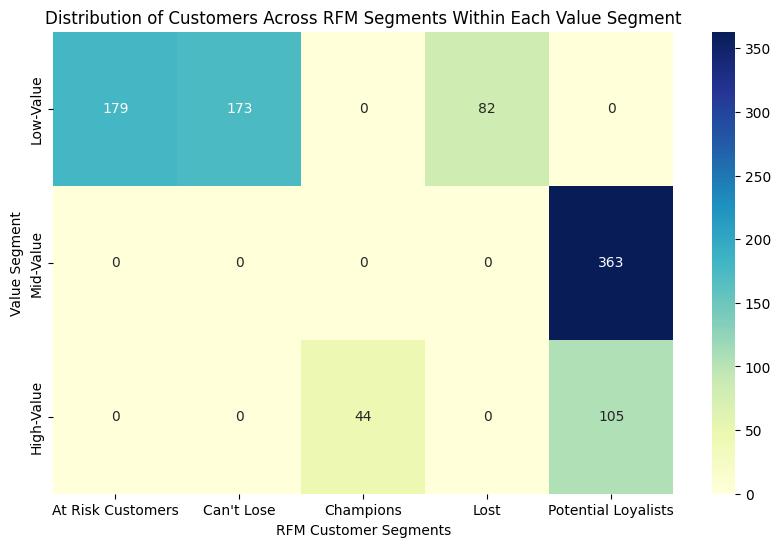

In [ ]:
# Analyzing the distribution of customers across different RFM customer segments within each value segment

# Pivoting the data to create a matrix suitable for the heatmap
heatmap_data = RFM_data.groupby(['Value Segment', 'RFM Customer Segments']).size().unstack()

# Creating the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Distribution of Customers Across RFM Segments Within Each Value Segment')
plt.xlabel('RFM Customer Segments')
plt.ylabel('Value Segment')

plt.show()

In [ ]:
# The distribution of RFM values within the Champions segment

champions_data = RFM_data[RFM_data['RFM Customer Segments'] == 'Champions']

# Summary statistics for Recency, Frequency, and Monetary values
recency_stats = champions_data['Recency_value'].describe()
frequency_stats = champions_data['Frequency_value'].describe()
monetary_stats = champions_data['Monetary_value'].describe()

print(recency_stats)
print(frequency_stats)
print(monetary_stats)

count     44.000000
mean     135.840909
std       11.199965
min      122.000000
25%      127.000000
50%      131.500000
75%      145.250000
max      161.000000
Name: Recency_value, dtype: float64
count    44.000000
mean      1.909091
std       0.473394
min       1.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       3.000000
Name: Frequency_value, dtype: float64
count      44.000000
mean     1142.002273
std       449.995376
min       123.060000
25%       968.560000
50%      1048.385000
75%      1386.412500
max      2379.450000
Name: Monetary_value, dtype: float64


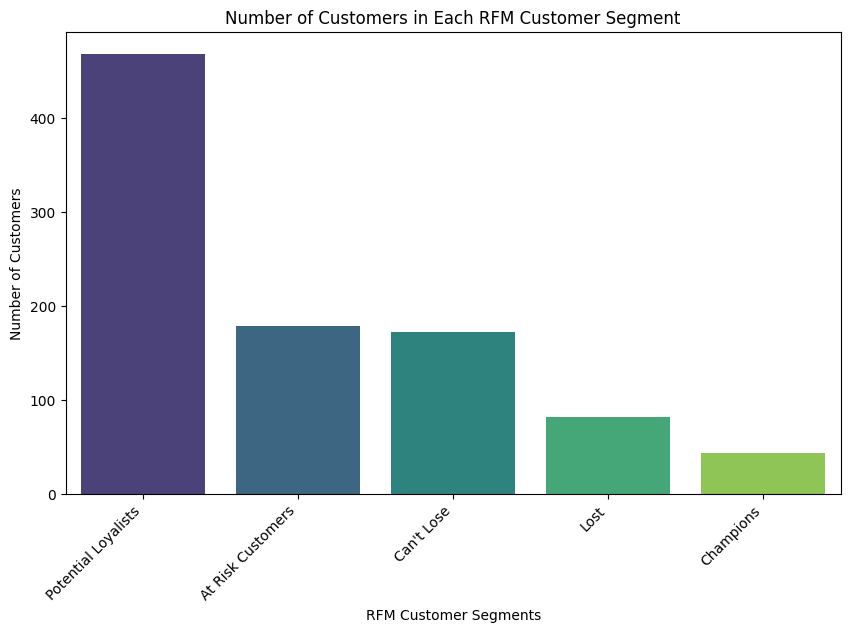

In [ ]:
# The number of customers in all of the segments:

# Calculating the segment counts
segment_counts = RFM_data['RFM Customer Segments'].value_counts().reset_index()
segment_counts.columns = ['RFM Customer Segments', 'Count']

# Sorting the segments by count in descending order
segment_counts = segment_counts.sort_values(by='Count', ascending=False)

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='RFM Customer Segments', y='Count', data=segment_counts, palette='viridis')
plt.title('Number of Customers in Each RFM Customer Segment')
plt.xlabel('RFM Customer Segments')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for readability

plt.show()


In [ ]:
# To examine the recency, frequency, and monetary scores of all the segments

# Calculating the average Recency, Frequency, and Monetary scores for each segment
segment_scores = RFM_data.groupby('RFM Customer Segments')[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].mean().reset_index()


# Creating a grouped bar chart to compare segment scores
fig = go.Figure()

# Adding bars for Recency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['RecencyScore'],
    name='Recency Score',
    marker_color='rgb(158,202,225)'
))

# Adding bars for Frequency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['FrequencyScore'],
    name='Frequency Score',
    marker_color='rgb(94,158,217)'
))

# Adding bars for Monetary score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['MonetaryScore'],
    name='Monetary Score',
    marker_color='rgb(32,102,148)'
))

# Updating the layout
fig.update_layout(
    title='Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores',
    xaxis_title='RFM Segments',
    yaxis_title='Score',
    barmode='group',
    showlegend=True
)

fig.show()
